In [2]:
#Figure 4 - final figure to Keynote - October 2023
# Trend 2016-2020 for VIIRS CCI and GSM
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import glob
import dask

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
import statsmodels.api as sm
import esmtools

import cmocean
import colorcet as cc
import cartopy
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#cartopy.config["data_dir"] = './cartopy_shapefiles'

ImportError: cannot import name hashtable

In [11]:
ls -t /home/datawork-lops-oh/biogeo/AI/CNN_CHLORO/trend_map/Trend_log_chl_2002-01_2011-12*

In [13]:
data_input = '/home/datawork-lops-oh/biogeo/AI/CNN_CHLORO/MULTIOBS_GLO_BIO_BGC_3D_REP_015_010/Surface/'
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds = xr.open_mfdataset(data_input + 'CMEMS_chl_*.nc')
    ds = ds.resample(time="1M").mean()


TypeError: __init__() got an unexpected keyword argument 'base'

In [5]:
#Compute the trend for VIIRS observation
ds_input = xr.open_mfdataset('/home/datawork-lops-oh/biogeo/AI/CNN_CHLORO/INPUT/Input_obs9_*.nc')
sensor = 'VIR'
ds = xr.open_mfdataset('/home2/datawork/epauthen/Globcolour_coarse/' + sensor + '*.nc')
ds = ds.rename({'CHL1_coarse':'chloro'})
d1 = '2012-01'
d2 = '2020-12'
ds = ds.sel(time = slice(d1,d2),latitude = slice(-50,50))
ds = ds.assign(variables={"mask": (('latitude','longitude'), ds_input.mask.data)}) 
ds = ds.where(ds.mask == 6)
#trend on deseasonalised or raw
ds = ds.assign(variables={"chl_log": (('time','latitude','longitude'), np.log(ds.chloro.data))})

In [6]:
ds = ds.drop(['chloro','mask']).load()
ds_season = ds.groupby('time.month').mean(dim='time').chl_log
ds_monthly = ds.groupby('time.month')
ds = ds.assign(variables={"chl_deseason": (('time','latitude','longitude'), (ds_monthly - ds_monthly.mean(dim='time')).chl_log.data)})
ds = ds.drop(['chl_log'])
ds_lr = esmtools.stats.linregress(ds, dim='time', nan_policy='omit') 

In [7]:
ds_lr.to_netcdf('/home/datawork-lops-oh/biogeo/AI/CNN_CHLORO/trend_map/' + 
                "Trend_log_chl_"+ str(d1)  + "_" + str(d2) + "_" +  str(sensor) +".nc")

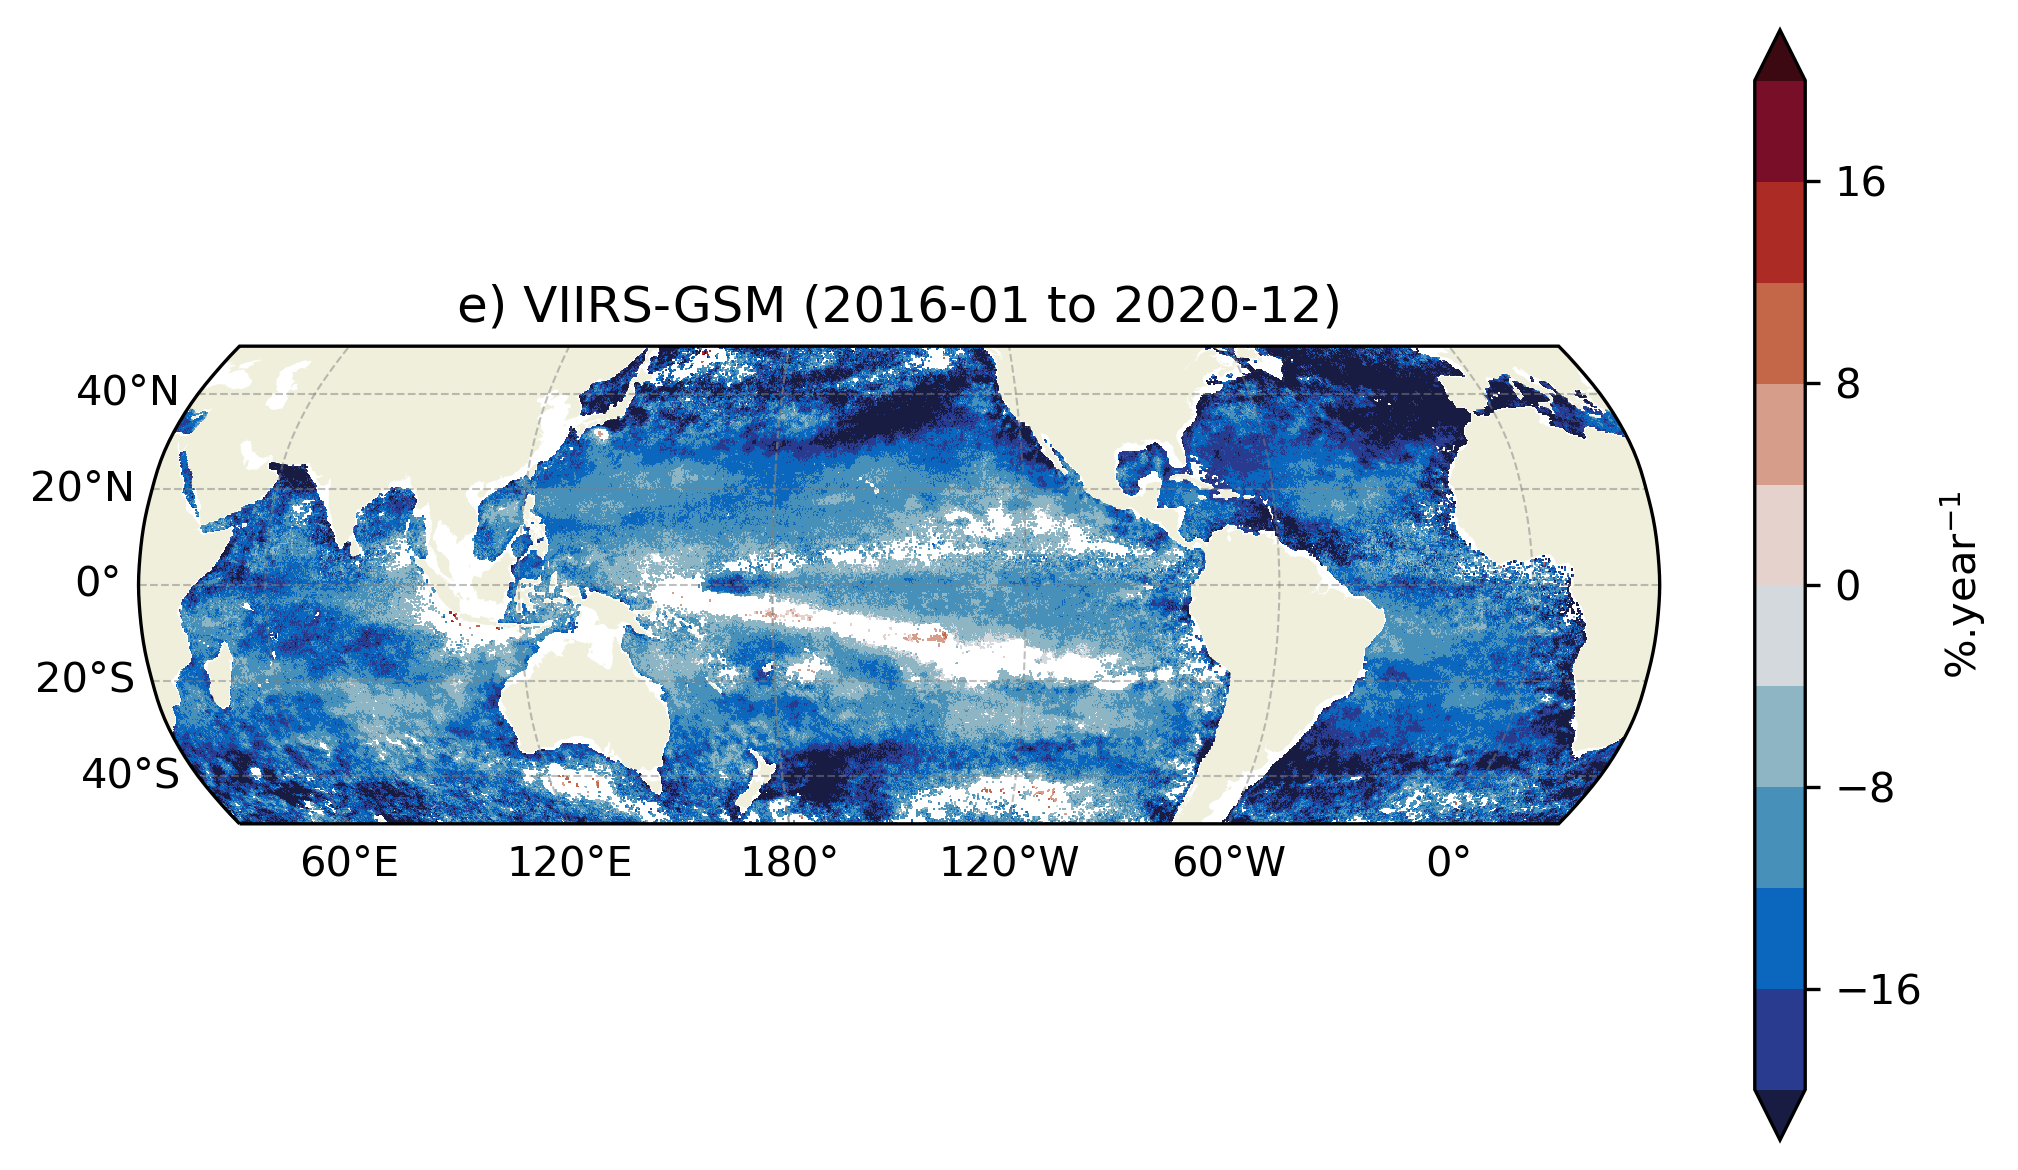

In [56]:
cm = cmocean.cm.balance
vm = 20
unit = '%.year$^{-1}$'
proj=ccrs.Robinson(central_longitude = 210)
land_feature = cfeature.NaturalEarthFeature(
category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
subplot_kw = {'projection': proj} 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4), dpi=300, subplot_kw=subplot_kw, tight_layout=True)
ds_sig = ds_lr.where(ds_lr.sel(parameter='pvalue')<=0.05)
(ds_sig.chl_deseason.sel(parameter='slope')*1200).plot(cmap = cm,transform=ccrs.PlateCarree(),ax = ax,vmin = -vm,vmax = vm
                                            ,cbar_kwargs=dict(label=unit),levels =11)
ax.set_title("e) VIIRS-GSM (" + str(d1) + ' to ' + str(d2) + ')')
ax.grid(True)
ax.add_feature(land_feature) #, edgecolor='black')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.savefig('Figure_GRL/Fig4_'+str(period)+'_VIIRS_deseason.png', bbox_inches='tight')


In [51]:
#Add maps
path = '/home/datawork-lops-oh/biogeo/AI/CNN_CHLORO/trend_map/'
d1 = '2016-01'
d2 = '2020-12'
period = str(d1) + '_' + str(d2)

CCI_0   = xr.open_dataset(path + "Trend_log_chl_"+str(period)+"_cci.nc")
GSM_0   = xr.open_dataset(path + "Trend_log_chl_"+str(period)+"_gsm.nc")

#Apply mask to all maps
ds_input = xr.open_dataset('/home/datawork-lops-oh/biogeo/AI/CNN_CHLORO/INPUT/Input_obs9_1996.nc')
CCI_0 = CCI_0.where(ds_input['mask'] == 6,drop = True) 
GSM_0 = GSM_0.where(ds_input['mask'] == 6,drop = True) 


In [52]:
cm = cmocean.cm.balance
unit = '%.year$^{-1}$'
proj=ccrs.Robinson(central_longitude = 210)
land_feature = cfeature.NaturalEarthFeature(
category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
subplot_kw = {'projection': proj} 

ds_map    = [CCI_0       , GSM_0 ]
title_map = ['c) OC-CCI' , 'a) Globcolour GSM']
w         = [1200       ,1200                 ]

CPU times: user 14 s, sys: 36 ms, total: 14.1 s
Wall time: 14.1 s


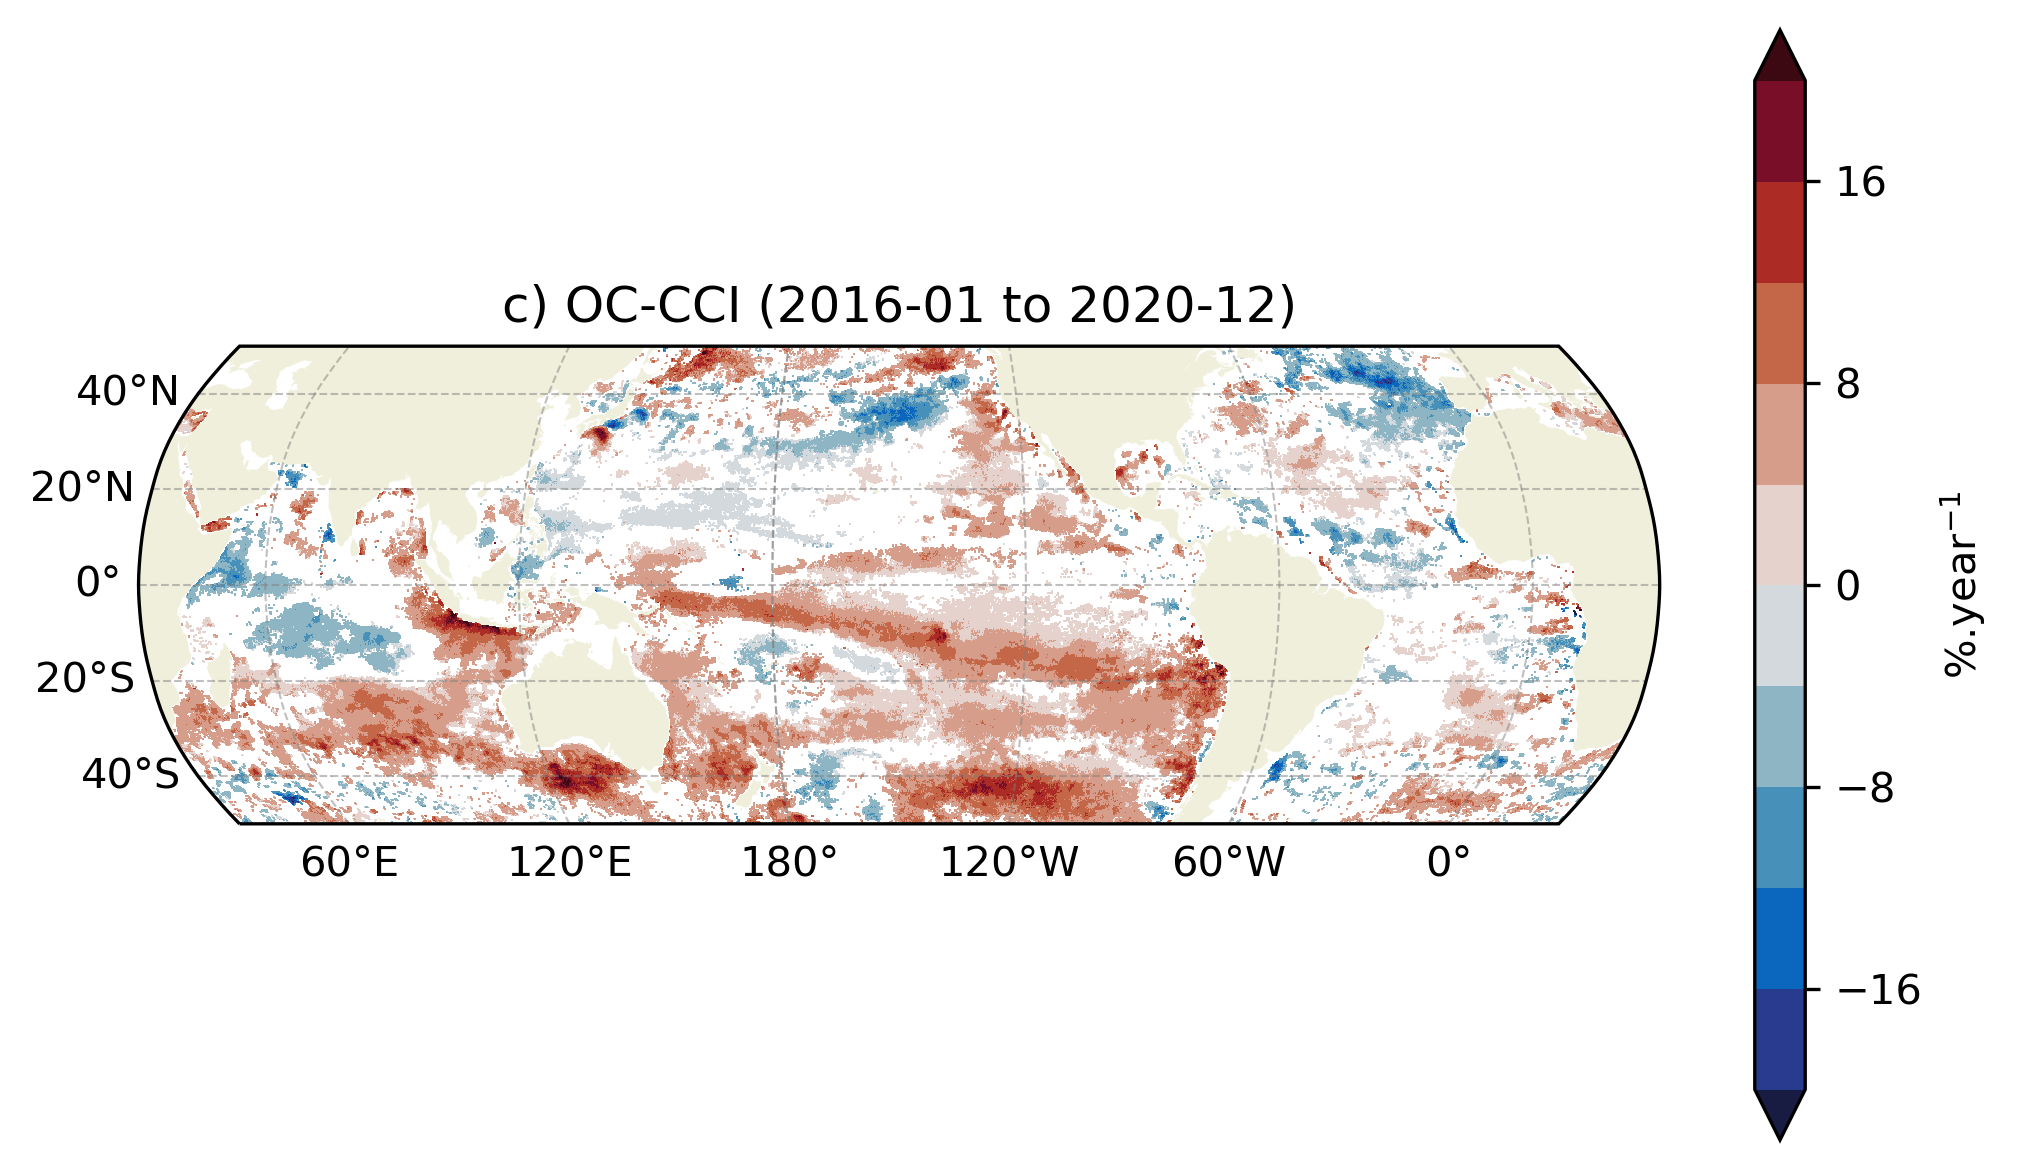

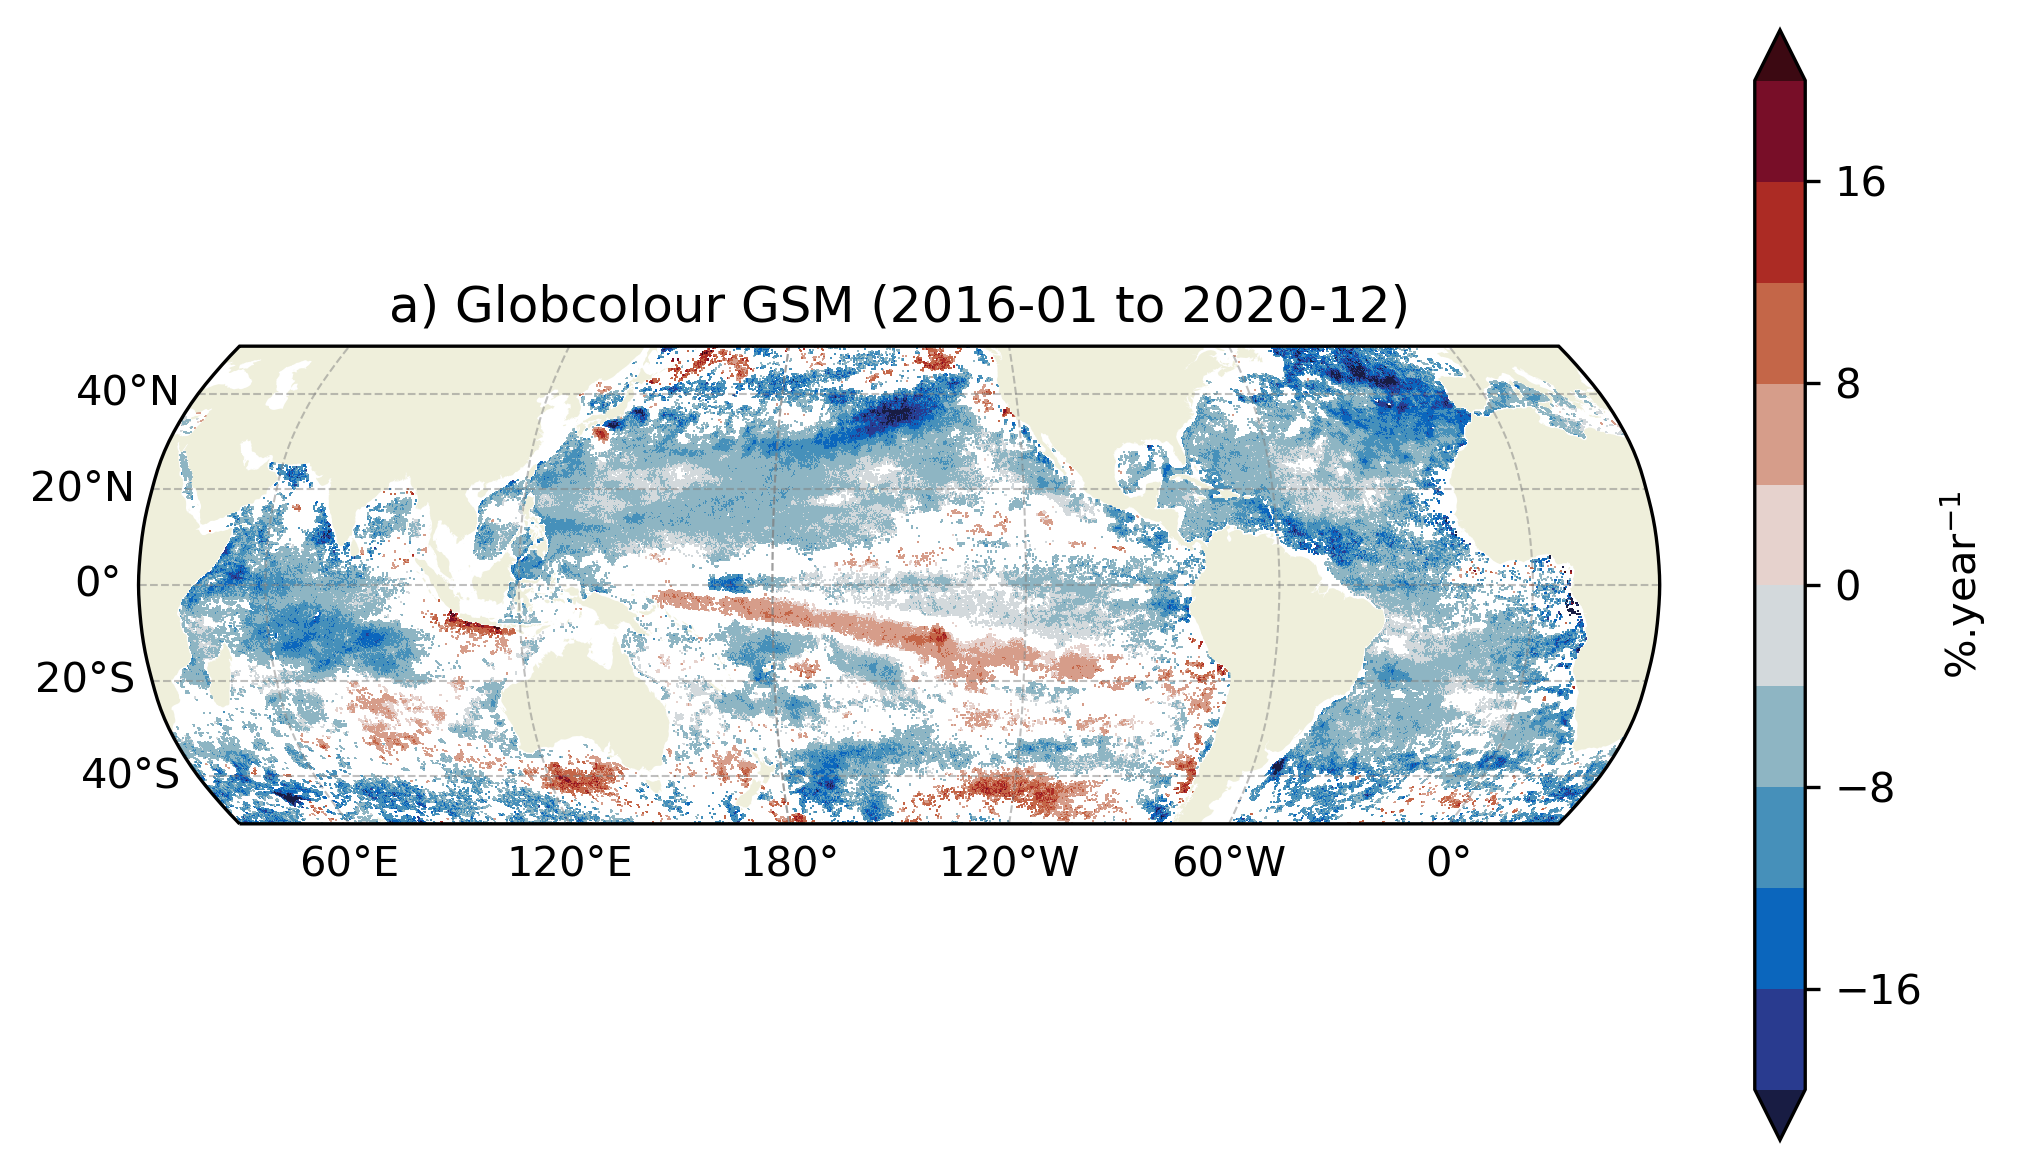

In [58]:
%%time
#Discrete white and 10
vm = 20
for i in np.arange(len(title_map)):
    ds_i = ds_map[i]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,4), dpi=300, subplot_kw=subplot_kw
                           , tight_layout=True)
    ds_sig = ds_i.where(ds_i.sel(parameter='pvalue')<=0.05)
    (ds_sig.chl_deseason.sel(parameter='slope')*1200).plot(vmin = -vm,vmax = vm,cmap = cm,transform=ccrs.PlateCarree(),ax = ax
                                                ,cbar_kwargs=dict(label=unit),levels = 11)
    ax.set_title(title_map[i] + " (" + str(d1) + ' to ' + str(d2) + ')')
    ax.grid(True)
    ax.add_feature(land_feature) #, edgecolor='black')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    plt.savefig('Figure_GRL/Fig4_'+str(period)+'_'+str(title_map[i])+'_deseason.png', bbox_inches='tight')